In [1]:
# Importing necessary Libraries
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import kurtosis, skew

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('tableau-colorblind10')

## Dataset
The goal of this project is to `predict the potentially fraudulent providers` based on the claims filed by them.along with this, we will also discover important variables helpful in detecting the behaviour of potentially fraud providers. further, we will study fraudulent patterns in the provider's claims to understand the future behaviour of providers.

For the purpose of this project, we are considering Inpatient claims, Outpatient claims and Beneficiary details of each provider. Lets s see their details :

1) **Inpatient Data:** This data provides insights about the claims filed for those patients who are admitted in the hospitals. It also provides additional details like their admission and discharge dates and admit d diagnosis code.

2) **Outpatient Data:** This data provides details about the claims filed for those patients who visit hospitals and not admitted in it.

3) **Beneficiary Details Data:** This data contains beneficiary KYC details like health conditions,regioregion they belong to etc.

I will be reading the data using `Polars` both training and testing data.

In [3]:
# Reading Train data
train_beneficiary = pl.read_csv("../data/Train_Beneficiarydata.csv")
train_inpatient = pl.read_csv("../data/Train_Inpatientdata.csv", ignore_errors=True)
train_outpatient = pl.read_csv("../data/Train_Outpatientdata.csv")
train = pl.read_csv("../data/Train.csv")

# Reading Test data
test_beneficiary = pl.read_csv("../data/Test_Beneficiarydata.csv")
test_inpatient = pl.read_csv("../data/Test_Inpatientdata.csv", ignore_errors=True)
test_outpatient = pl.read_csv("../data/Test_Outpatientdata.csv")
test = pl.read_csv("../data/Test.csv")

I plan to explore each data file individually to focus on the unique insights and patterns within each dataset. This targeted approach will allow me to develop a deeper understanding of the data characteristics, quality, and potential relationships. Once the individual analyses are complete, I will integrate all the files to perform a comprehensive, unified analysis that captures the broader trends and interactions across datasets.

## Exploring Beneficiary Data

In [4]:
print(f"Shape of Train_Beneficiarydata: {train_beneficiary.shape}")
print(f"Shape of Test_Beneficiarydata: {test_beneficiary.shape}")

Shape of Train_Beneficiarydata: (138556, 25)
Shape of Test_Beneficiarydata: (63968, 25)


In [5]:
print(f"Columns in Train_Beneficiarydata: {train_beneficiary.columns}")

Columns in Train_Beneficiarydata: ['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']


In [6]:
train_beneficiary.schema

Schema([('BeneID', String),
        ('DOB', String),
        ('DOD', String),
        ('Gender', Int64),
        ('Race', Int64),
        ('RenalDiseaseIndicator', String),
        ('State', Int64),
        ('County', Int64),
        ('NoOfMonths_PartACov', Int64),
        ('NoOfMonths_PartBCov', Int64),
        ('ChronicCond_Alzheimer', Int64),
        ('ChronicCond_Heartfailure', Int64),
        ('ChronicCond_KidneyDisease', Int64),
        ('ChronicCond_Cancer', Int64),
        ('ChronicCond_ObstrPulmonary', Int64),
        ('ChronicCond_Depression', Int64),
        ('ChronicCond_Diabetes', Int64),
        ('ChronicCond_IschemicHeart', Int64),
        ('ChronicCond_Osteoporasis', Int64),
        ('ChronicCond_rheumatoidarthritis', Int64),
        ('ChronicCond_stroke', Int64),
        ('IPAnnualReimbursementAmt', Int64),
        ('IPAnnualDeductibleAmt', Int64),
        ('OPAnnualReimbursementAmt', Int64),
        ('OPAnnualDeductibleAmt', Int64)])

In [7]:
def get_stats(df):
    """
    Generates a comprehensive statistical summary of a Polars DataFrame.

    This function analyzes each column of the provided Polars DataFrame `df`
    and returns a summary containing:
      - Column names
      - Data types
      - Count of non-null values
      - Count of null values
      - Percentage of missing values
      - Number of unique values
      - Sample unique values
      - Kurtosis (for numeric columns)
      - Skewness (for numeric columns)

    Parameters:
    -----------
    df : pl.DataFrame
        The input Polars DataFrame to analyze.

    Returns:
    --------
    pl.DataFrame
        A summary DataFrame with the statistics for each column in the input DataFrame.
    """
    df = df.with_columns([
        pl.when(pl.col(col) == "NA").then(None).otherwise(pl.col(col)).alias(col)
        if df[col].dtype == pl.Utf8 else df[col]
        for col in df.columns
    ])
    
    n_rows = df.shape[0]
    columns = df.columns
    dtypes = df.dtypes
    total_cnt = df.select(pl.col("*").drop_nulls().count())
    null_cnt = df.select([
        (n_rows - pl.col(col).drop_nulls().count()).alias(f"{col}_null_count")
        for col in df.columns
    ])
    missing_perc = null_cnt.with_columns([
        (pl.col(col) / n_rows * 100).alias(f"{col}_missing_percentage")
        for col in null_cnt.columns
    ])
    unq_vals = {col: df[col].n_unique() for col in df.columns}
    total_unqs = {col: df[col].unique().to_list() for col in df.columns}
    numeric_cols = df.select(pl.col(pl.Int64) | pl.col(pl.Float64))

    if numeric_cols.columns:
        kurtosis_vals = {}
        skewness_vals = {}

        for col in numeric_cols.columns:
            data = numeric_cols.select(pl.col(col)).to_numpy().flatten()
            kurtosis_vals[col] = kurtosis(data)
            skewness_vals[col] = skew(data)

        kurtosis_list = [kurtosis_vals.get(col, None) for col in df.columns]
        skewness_list = [skewness_vals.get(col, None) for col in df.columns]
    else:
        kurtosis_list = [None] * len(df.columns)
        skewness_list = [None] * len(df.columns)

    summary = pl.DataFrame({
        "Columns": columns,
        "Data Type": dtypes,
        "Non-Null count": [total_cnt[col][0] for col in df.columns],
        "Null count": [null_cnt[f"{col}_null_count"][0] for col in df.columns],
        "Missing Percentage (%)": [missing_perc[f"{col}_null_count_missing_percentage"][0] for col in df.columns],
        "Number of Unique Values": [unq_vals[col] for col in df.columns],
        "Sample Unique Values": [total_unqs[col] for col in df.columns]
    }, strict=False)

    summary = summary.with_columns([
        pl.Series("Kurtosis", kurtosis_list),
        pl.Series("Skewness", skewness_list)
    ])

    return summary

In [8]:
beneficiary_stats = get_stats(train_beneficiary)

In [9]:
beneficiary_stats

Columns,Data Type,Non-Null count,Null count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Kurtosis,Skewness
str,object,i64,i64,f64,i64,list[str],f64,f64
"""BeneID""",String,138556,0,0.0,138556,"[""BENE55225"", ""BENE108255"", … ""BENE76563""]",null,null
"""DOB""",String,138556,0,0.0,900,"[""1919-10-01"", ""1945-07-01"", … ""1957-04-01""]",null,null
"""DOD""",String,1421,137135,98.974422,12,"[""2009-03-01"", ""2009-12-01"", … ""2009-07-01""]",null,null
"""Gender""",Int64,138556,0,0.0,2,"[""1"", ""2""]",-1.917846,-0.286625
"""Race""",Int64,138556,0,0.0,4,"[""1"", ""2"", … ""5""]",14.006224,3.58442
…,…,…,…,…,…,…,…,…
"""ChronicCond_stroke""",Int64,138556,0,0.0,2,"[""1"", ""2""]",7.73474,-3.120055
"""IPAnnualReimbursementAmt""",Int64,138556,0,0.0,3004,"[""-8000"", ""-1400"", … ""161470""]",31.024055,4.636492
"""IPAnnualDeductibleAmt""",Int64,138556,0,0.0,147,"[""0"", ""1068"", … ""38272""]",268.099503,10.453149


In [10]:
has_nulls = beneficiary_stats.filter(pl.col("Null count") > 0)

print("Columns with null values:")
print(has_nulls.select(["Columns", "Null count", "Missing Percentage (%)"]))

Columns with null values:
shape: (1, 3)
┌─────────┬────────────┬────────────────────────┐
│ Columns ┆ Null count ┆ Missing Percentage (%) │
│ ---     ┆ ---        ┆ ---                    │
│ str     ┆ i64        ┆ f64                    │
╞═════════╪════════════╪════════════════════════╡
│ DOD     ┆ 137135     ┆ 98.974422              │
└─────────┴────────────┴────────────────────────┘


In [11]:
# Number of unique beneficiaries in Training Data
beneficiary_row = beneficiary_stats.filter(pl.col("Columns") == "BeneID")
unique_beneficiaries = beneficiary_row.select(pl.col("Number of Unique Values")).item()

print(f"Number of unique beneficiaries in the dataset: {unique_beneficiaries}")

Number of unique beneficiaries in the dataset: 138556


In [12]:
# Gender distribution transformation (1: Male, 2: Female → 1: Male, 0: Female)
train_beneficiary = train_beneficiary.with_columns(
    (pl.when(pl.col("Gender") == 2).then(0).otherwise(1)).alias("Gender")
)

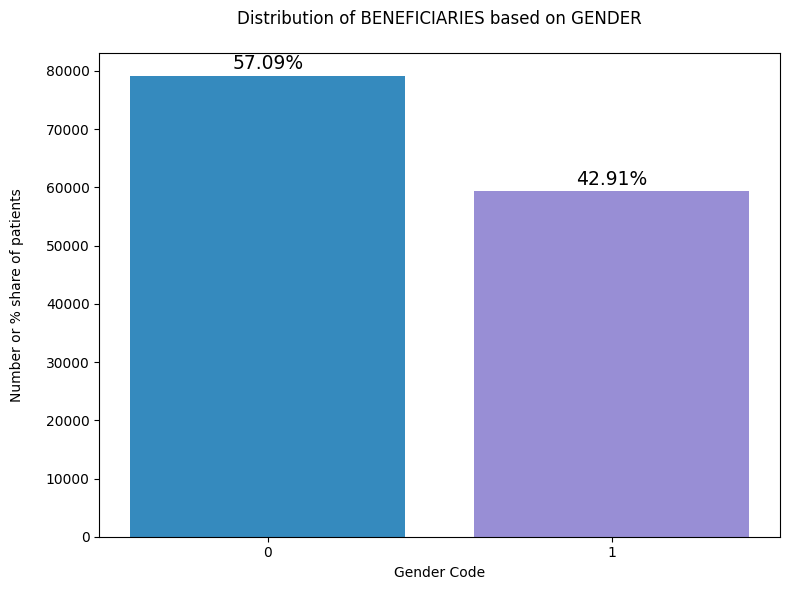

In [13]:
gender_counts = (
    train_beneficiary
    .group_by("Gender")
    .agg(pl.len().alias("count"))
    .sort("Gender")
)

gender_pd = gender_counts.to_pandas()

# Visualizing the distribution of beneficiaries based on Gender
plt.figure(figsize=(8, 6))
fig = plt.bar(
    gender_pd["Gender"].astype(str),
    gender_pd["count"],
    color=['#358ABE', '#988ED5']
)

total = gender_pd["count"].sum()
for i, count in enumerate(gender_pd["count"]):
    percentage = round((count / total) * 100, 2)
    plt.text(i, count * 1.015, f'{percentage}%', ha='center', fontsize=13.5)

plt.xlabel("Gender Code")
plt.ylabel("Number or % share of patients\n")
plt.title("Distribution of BENEFICIARIES based on GENDER\n")
plt.tight_layout()
plt.show()

In [14]:
# Calculating Age from DOB
train_beneficiary = train_beneficiary.with_columns(
    pl.col("DOB").str.strptime(pl.Date, "%Y-%m-%d").alias("DOB")
)
train_beneficiary = train_beneficiary.with_columns(
    pl.col("DOB").dt.year().alias("Patient_Age_Year"),
    pl.col("DOB").dt.month().alias("Patient_Age_Month")
)

In [15]:
bene_age_year_df = (
    train_beneficiary
    .select("Patient_Age_Year")
    .group_by("Patient_Age_Year")
    .agg(pl.len().alias("num_of_beneficiaries"))
    .sort("Patient_Age_Year")
    .rename({"Patient_Age_Year": "year"})
)

bene_age_year_pd = bene_age_year_df.to_pandas()

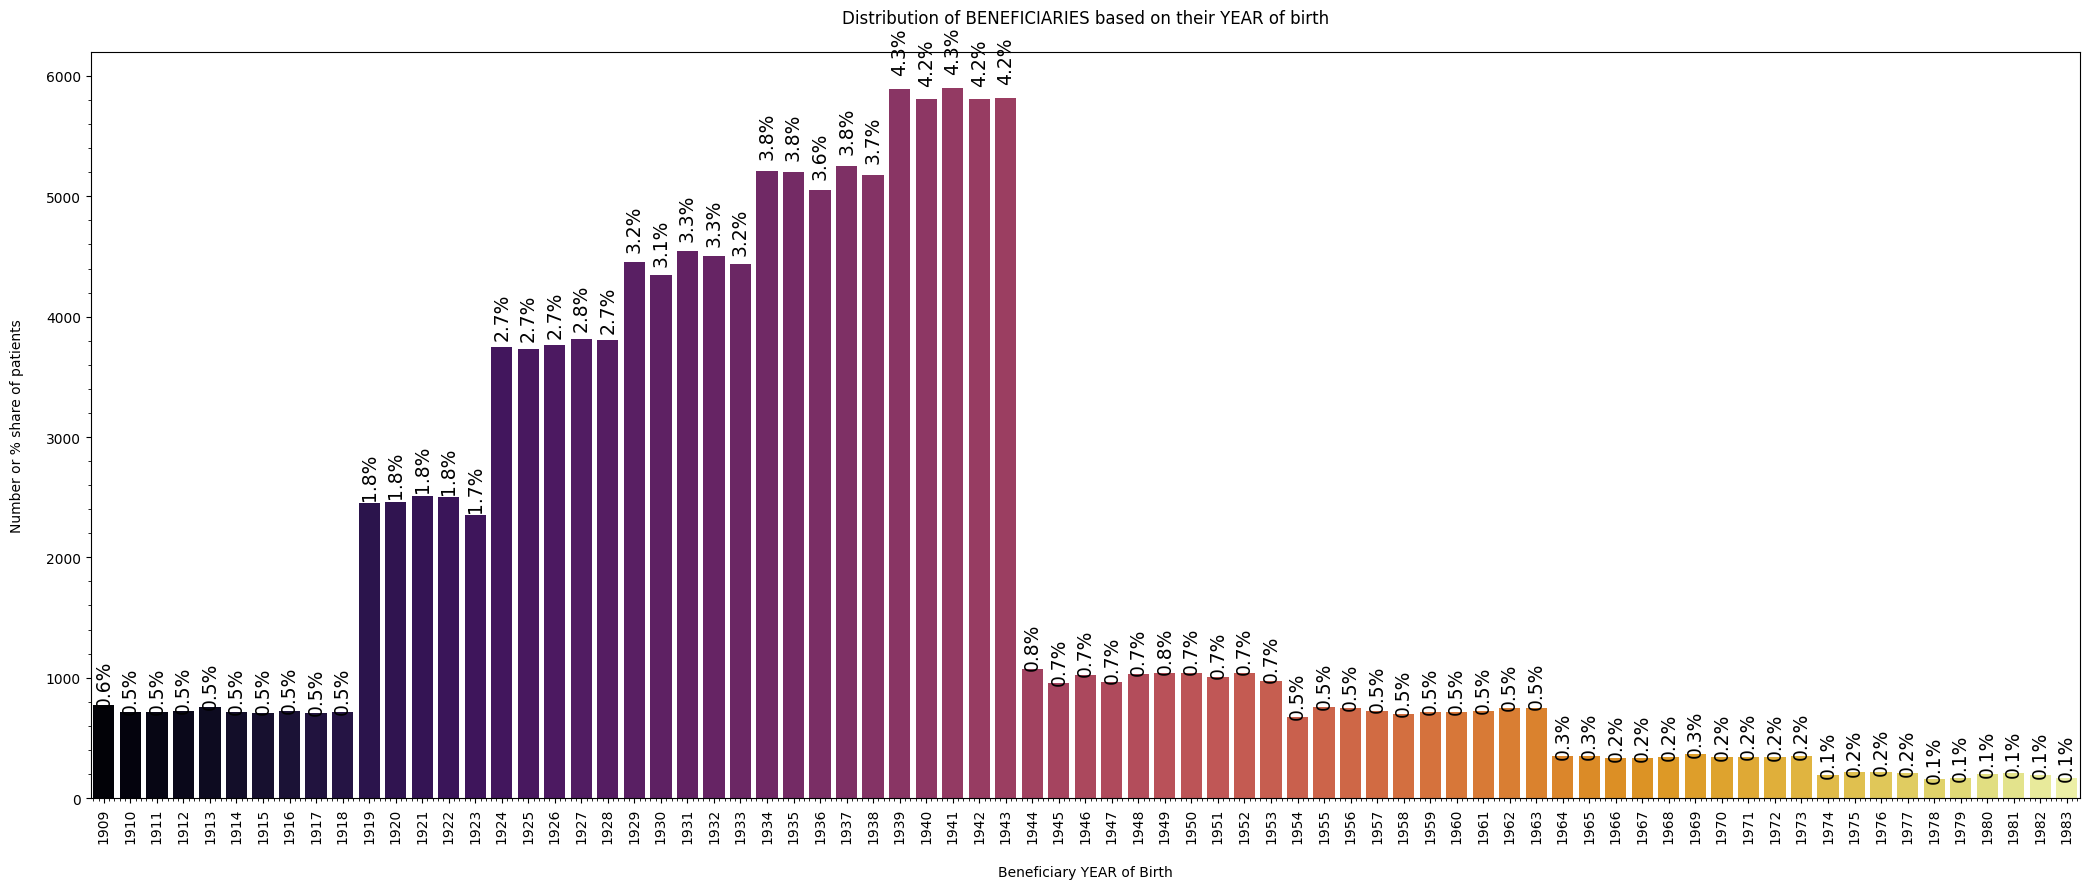

In [16]:
plt.figure(figsize=(21, 9))

fig = sns.barplot(data=bene_age_year_pd, x='year', y='num_of_beneficiaries', palette='inferno')

total_beneficiaries = train_beneficiary.shape[0]
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    percentage = round((height * 100) / total_beneficiaries, 1)
    fig.annotate(f'{percentage}%', (x + width / 2, y + height * 1.025), ha='center', fontsize=13.5, rotation=90)

plt.xlabel("\nBeneficiary YEAR of Birth")
plt.ylabel("Number or % share of patients\n")
plt.title("Distribution of BENEFICIARIES based on their YEAR of birth\n")
plt.xticks(rotation=90)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [17]:
# Adding "Dead_or_Alive" column (1: Dead, 0: Alive)
train_beneficiary = train_beneficiary.with_columns(
    (pl.when(pl.col("DOD").is_null()).then(0).otherwise(1)).alias("Dead_or_Alive")
)

In [18]:
# Filling NaN values in "DOD" column with the latest known death date
max_dod = train_beneficiary["DOD"].drop_nulls().max()

train_beneficiary = train_beneficiary.with_columns(
    pl.when(pl.col("DOD").is_null())
    .then(pl.lit(max_dod))
    .otherwise(pl.col("DOD"))
    .alias("DOD")
)

In [19]:
# Ensuring "DOD" and "DOB" are in Date format
train_beneficiary = train_beneficiary.with_columns([
    pl.col("DOD").cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("DOD"),
    pl.col("DOB").cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("DOB")
])

# Calculating age only for non-null DOD values
train_beneficiary = train_beneficiary.with_columns(
    pl.when(pl.col("DOD").is_not_null())
    .then(((pl.col("DOD") - pl.col("DOB")).dt.total_days() / 365.0).round(1))
    .otherwise(None)
    .alias("AGE")
)

# Dropping DOD column
train_beneficiary = train_beneficiary.drop("DOD")

In [20]:
# train_beneficiary = train_beneficiary.with_columns(
#     pl.when(pl.col("AGE") <= 40)
#     .then("Young")
#     .when(pl.col("AGE") <= 60)
#     .then("Mid")
#     .when(pl.col("AGE") <= 80)
#     .then("Old")
#     .otherwise("Very Old")
#     .alias("AGE_groups")
# )

## Exploring In-patients and Out-patients Data

In [21]:
print(f"Shape of Training InPatient Data: {train_inpatient.shape}")
print(f"Shape of Training OutPatient Data: {train_outpatient.shape}")
print(f"="*50)
print(f"Shape of Testing InPatient Data: {test_inpatient.shape}")
print(f"Shape of Testing OutPatient Data: {test_outpatient.shape}")

Shape of Training InPatient Data: (40474, 30)
Shape of Training OutPatient Data: (517737, 27)
Shape of Testing InPatient Data: (9551, 30)
Shape of Testing OutPatient Data: (125841, 27)


In [22]:
print(f"Columns in InPatient Data: {train_inpatient.columns}")

Columns in InPatient Data: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']


In [23]:
print(f"Columns in OutPatient Data: {train_outpatient.columns}")

Columns in OutPatient Data: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode']


In [24]:
train_inpatient.schema

Schema([('BeneID', String),
        ('ClaimID', String),
        ('ClaimStartDt', String),
        ('ClaimEndDt', String),
        ('Provider', String),
        ('InscClaimAmtReimbursed', Int64),
        ('AttendingPhysician', String),
        ('OperatingPhysician', String),
        ('OtherPhysician', String),
        ('AdmissionDt', String),
        ('ClmAdmitDiagnosisCode', String),
        ('DeductibleAmtPaid', String),
        ('DischargeDt', String),
        ('DiagnosisGroupCode', Int64),
        ('ClmDiagnosisCode_1', Int64),
        ('ClmDiagnosisCode_2', String),
        ('ClmDiagnosisCode_3', String),
        ('ClmDiagnosisCode_4', String),
        ('ClmDiagnosisCode_5', String),
        ('ClmDiagnosisCode_6', String),
        ('ClmDiagnosisCode_7', String),
        ('ClmDiagnosisCode_8', String),
        ('ClmDiagnosisCode_9', String),
        ('ClmDiagnosisCode_10', String),
        ('ClmProcedureCode_1', String),
        ('ClmProcedureCode_2', String),
        ('ClmProcedur

In [25]:
train_outpatient.schema

Schema([('BeneID', String),
        ('ClaimID', String),
        ('ClaimStartDt', String),
        ('ClaimEndDt', String),
        ('Provider', String),
        ('InscClaimAmtReimbursed', Int64),
        ('AttendingPhysician', String),
        ('OperatingPhysician', String),
        ('OtherPhysician', String),
        ('ClmDiagnosisCode_1', String),
        ('ClmDiagnosisCode_2', String),
        ('ClmDiagnosisCode_3', String),
        ('ClmDiagnosisCode_4', String),
        ('ClmDiagnosisCode_5', String),
        ('ClmDiagnosisCode_6', String),
        ('ClmDiagnosisCode_7', String),
        ('ClmDiagnosisCode_8', String),
        ('ClmDiagnosisCode_9', String),
        ('ClmDiagnosisCode_10', String),
        ('ClmProcedureCode_1', String),
        ('ClmProcedureCode_2', String),
        ('ClmProcedureCode_3', String),
        ('ClmProcedureCode_4', String),
        ('ClmProcedureCode_5', String),
        ('ClmProcedureCode_6', String),
        ('DeductibleAmtPaid', Int64),
        (

In [26]:
inpatient_stats = get_stats(train_inpatient)

In [27]:
inpatient_stats

Columns,Data Type,Non-Null count,Null count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Kurtosis,Skewness
str,object,i64,i64,f64,i64,list[str],f64,f64
"""BeneID""",String,40474,0,0.0,31289,"[""BENE94491"", ""BENE146650"", … ""BENE70770""]",null,null
"""ClaimID""",String,40474,0,0.0,40474,"[""CLM41026"", ""CLM51579"", … ""CLM34539""]",null,null
"""ClaimStartDt""",String,40474,0,0.0,398,"[""2009-02-27"", ""2009-03-28"", … ""2009-06-26""]",null,null
"""ClaimEndDt""",String,40474,0,0.0,365,"[""2009-01-19"", ""2009-03-20"", … ""2009-12-24""]",null,null
"""Provider""",String,40474,0,0.0,2092,"[""PRV53256"", ""PRV54514"", … ""PRV54368""]",null,null
…,…,…,…,…,…,…,…,…
"""ClmProcedureCode_2""",String,5454,35020,86.524683,298,"[""7850"", ""7810"", … ""436""]",null,null
"""ClmProcedureCode_3""",String,965,39509,97.615753,155,"[""3009"", ""4299"", … ""5363""]",null,null
"""ClmProcedureCode_4""",String,116,40358,99.713396,49,"[""2763"", ""496"", … ""3844""]",null,null


In [28]:
ip_has_nulls = inpatient_stats.filter(pl.col("Null count") > 0)

print("Columns with null values:")
print(
    ip_has_nulls
    .sort("Null count", descending=True)
    .select(["Columns", "Null count", "Missing Percentage (%)"])
)

Columns with null values:
shape: (21, 3)
┌─────────────────────┬────────────┬────────────────────────┐
│ Columns             ┆ Null count ┆ Missing Percentage (%) │
│ ---                 ┆ ---        ┆ ---                    │
│ str                 ┆ i64        ┆ f64                    │
╞═════════════════════╪════════════╪════════════════════════╡
│ ClmProcedureCode_6  ┆ 40474      ┆ 100.0                  │
│ ClmProcedureCode_5  ┆ 40465      ┆ 99.977764              │
│ ClmProcedureCode_4  ┆ 40358      ┆ 99.713396              │
│ ClmProcedureCode_3  ┆ 39509      ┆ 97.615753              │
│ ClmDiagnosisCode_10 ┆ 36547      ┆ 90.297475              │
│ …                   ┆ …          ┆ …                      │
│ DeductibleAmtPaid   ┆ 899        ┆ 2.221179               │
│ ClmDiagnosisCode_3  ┆ 676        ┆ 1.670208               │
│ ClmDiagnosisCode_2  ┆ 226        ┆ 0.558383               │
│ DiagnosisGroupCode  ┆ 113        ┆ 0.279192               │
│ AttendingPhysician  ┆ 112  

In [29]:
onpatient_stats = get_stats(train_outpatient)

In [30]:
onpatient_stats

Columns,Data Type,Non-Null count,Null count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Kurtosis,Skewness
str,object,i64,i64,f64,i64,list[str],f64,f64
"""BeneID""",String,517737,0,0.0,133980,"[""BENE150294"", ""BENE65663"", … ""BENE40262""]",null,null
"""ClaimID""",String,517737,0,0.0,517737,"[""CLM224639"", ""CLM285628"", … ""CLM524072""]",null,null
"""ClaimStartDt""",String,517737,0,0.0,385,"[""2009-08-29"", ""2009-07-10"", … ""2009-08-22""]",null,null
"""ClaimEndDt""",String,517737,0,0.0,366,"[""2009-03-19"", ""2009-12-17"", … ""2009-07-31""]",null,null
"""Provider""",String,517737,0,0.0,5012,"[""PRV56734"", ""PRV53249"", … ""PRV52748""]",null,null
…,…,…,…,…,…,…,…,…
"""ClmProcedureCode_4""",String,2,517735,99.999614,3,"[""7840"", ""311"", null]",null,null
"""ClmProcedureCode_5""",String,0,517737,100.0,1,[null],null,null
"""ClmProcedureCode_6""",String,0,517737,100.0,1,[null],null,null


In [31]:
op_has_nulls = onpatient_stats.filter(pl.col("Null count") > 0)

print("Columns with null values:")
print(
    op_has_nulls
    .sort("Null count", descending=True)
    .select(["Columns", "Null count", "Missing Percentage (%)"])
)

Columns with null values:
shape: (19, 3)
┌────────────────────┬────────────┬────────────────────────┐
│ Columns            ┆ Null count ┆ Missing Percentage (%) │
│ ---                ┆ ---        ┆ ---                    │
│ str                ┆ i64        ┆ f64                    │
╞════════════════════╪════════════╪════════════════════════╡
│ ClmProcedureCode_5 ┆ 517737     ┆ 100.0                  │
│ ClmProcedureCode_6 ┆ 517737     ┆ 100.0                  │
│ ClmProcedureCode_4 ┆ 517735     ┆ 99.999614              │
│ ClmProcedureCode_3 ┆ 517733     ┆ 99.999227              │
│ ClmProcedureCode_2 ┆ 517701     ┆ 99.993047              │
│ …                  ┆ …          ┆ …                      │
│ OtherPhysician     ┆ 322691     ┆ 62.327205              │
│ ClmDiagnosisCode_3 ┆ 314480     ┆ 60.741264              │
│ ClmDiagnosisCode_2 ┆ 195380     ┆ 37.737307              │
│ ClmDiagnosisCode_1 ┆ 10453      ┆ 2.018979               │
│ AttendingPhysician ┆ 1396       ┆ 0.269635